In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import PolynomialFeatures
import datetime 
import pytz
from pytz import timezone
import tarfile
from numpy import load
import os
from sklearn.manifold import TSNE
import h5py
from sklearn.decomposition import PCA as sklearnPCA
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
import scipy as sp
from scipy import spatial

In [3]:
h5 = h5py.File('sound_data_improved.hdf5', 'r')

In [4]:
d = h5['sound_data']

In [5]:
sample_nums = np.random.choice(range(3388858), 10000, replace = False)

In [6]:
index = np.zeros(d.shape[0]).astype('bool')
index[sample_nums] = True

In [8]:
pca = sklearnPCA()
fitted = pca.fit(d[index,'feature_vector'])

In [9]:
transformed = pca.fit_transform(d['feature_vector'])

In [10]:
pca_106 = sklearnPCA(106)  # project from 64 to 2 dimensions
projected = pca_106.fit_transform(d['feature_vector'])

In [11]:
projected_tsne = TSNE(n_components=2).fit_transform(projected[index])

Plot 1: num clusters = 2, silhouette score = 0.43699878, calinski harabasz score = 5746.68297974605, davies bouldin score = 1.0821429185432812
Plot 2: num clusters = 3, silhouette score = 0.3462546, calinski harabasz score = 4430.406334439546, davies bouldin score = 1.0369724128360902
Plot 3: num clusters = 4, silhouette score = 0.19862382, calinski harabasz score = 3755.3556226595347, davies bouldin score = 1.6394996923173264
Plot 4: num clusters = 5, silhouette score = 0.16740812, calinski harabasz score = 3195.8835717570832, davies bouldin score = 1.878685237599602
Plot 5: num clusters = 6, silhouette score = 0.16330495, calinski harabasz score = 2762.28312111044, davies bouldin score = 2.073489954588818
Plot 6: num clusters = 7, silhouette score = 0.16497247, calinski harabasz score = 2464.120120260552, davies bouldin score = 2.1010321664858322
Plot 7: num clusters = 8, silhouette score = 0.15168564, calinski harabasz score = 2201.1416987389875, davies bouldin score = 2.14511371900

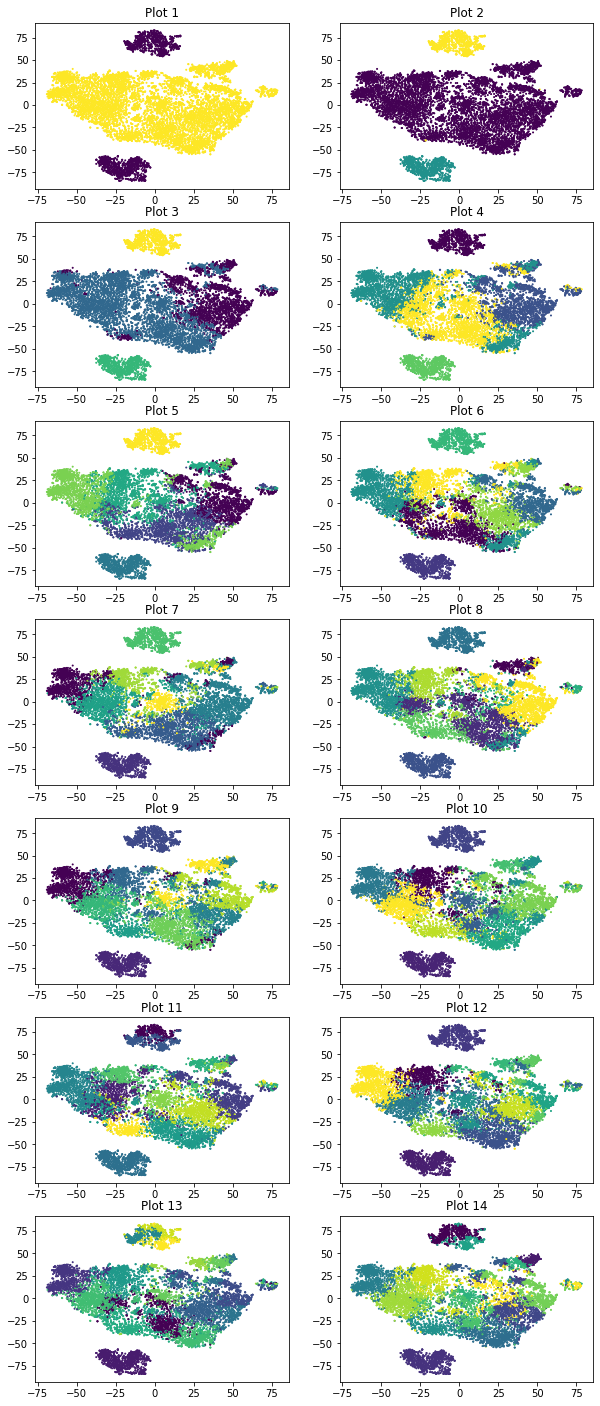

In [12]:
plt.figure(figsize=(10, 25))
idx = 1
for num_clusters in range(2, 16):
    mbk = MiniBatchKMeans(n_clusters=num_clusters, random_state=0)
    mbk_clusters = mbk.fit_predict(projected[index])
    plt.subplot(7, 2, idx)
    plt.scatter(projected_tsne[:, 0], projected_tsne[:, 1], c=mbk_clusters, s = 1)
    plt.title('Plot ' + str(idx))
    silhouette_score = metrics.silhouette_score(projected[index], mbk.labels_, metric='euclidean')
    c_h_score = metrics.calinski_harabasz_score(projected[index], mbk.labels_)
    d_b_score = davies_bouldin_score(projected[index], mbk.labels_) 
    print('Plot ' + str(idx) + ': num clusters = ' + str(num_clusters) + ', silhouette score = ' + str(silhouette_score) \
             + ', calinski harabasz score = ' + str(c_h_score) \
             + ', davies bouldin score = ' + str(d_b_score))
    idx += 1
# plt.tight_layout()
plt.show()

In [13]:
#8 is the best num of clusters
mbk = MiniBatchKMeans(n_clusters=8, random_state=0)
mbk_clusters = mbk.fit_predict(projected[index])
mbk.cluster_centers_

array([[-3.24471927e+00,  1.91266894e-01, -3.91818237e+00,
        -3.06345016e-01, -1.18494749e-01,  9.15280506e-02,
         5.20403743e-01,  2.05034062e-01,  7.32397214e-02,
         2.92235941e-01, -2.27691352e-01,  4.25276667e-01,
        -2.50798184e-02,  5.41474968e-02, -1.26732141e-01,
        -9.29611549e-02,  1.17074907e-01,  1.87218055e-01,
        -1.96461305e-01,  4.74905558e-02, -2.29406342e-01,
         8.90293047e-02, -4.05682959e-02, -6.99341819e-02,
         6.52403980e-02,  5.67703843e-02, -1.92754902e-02,
        -2.07651630e-02,  3.32638361e-02, -1.00188613e-01,
         3.99580831e-03,  7.38111436e-02, -3.09847742e-02,
         1.04363747e-01, -9.70973261e-03, -2.75260359e-02,
         1.42099231e-01, -3.23011614e-02,  3.40212472e-02,
         8.30101445e-02, -5.52386492e-02,  4.23561484e-02,
        -6.34883866e-02,  1.30158365e-01,  1.97361652e-02,
        -5.79508841e-02,  3.66847739e-02,  1.07320407e-02,
        -1.29728643e-02, -2.19630376e-02, -4.61914530e-0

In [14]:
mbk.labels_.shape

(10000,)

# Nearest Neighbors and Corresponding Audio Files

In [17]:
tree = spatial.KDTree(projected[index])

In [18]:
tree.query(mbk.cluster_centers_, 5)

(array([[2.73977955, 2.74045406, 2.87618115, 2.99133018, 3.00227397],
        [3.41478283, 3.44460256, 3.49884627, 3.55718517, 3.60263317],
        [3.72543913, 3.75500498, 3.87904504, 3.96403656, 3.9948386 ],
        [3.53588522, 3.65697961, 3.69707023, 3.71527758, 3.72166854],
        [3.4718294 , 3.57723375, 3.63718642, 3.67945501, 3.73550934],
        [3.70951684, 3.79810957, 3.97310634, 3.98387245, 3.98443161],
        [4.32040654, 4.58728174, 4.60539255, 4.60982767, 4.61252541],
        [4.39812809, 4.62744076, 4.64512031, 4.65585919, 4.74796673]]),
 array([[8026, 7300, 7859, 6181, 4234],
        [2595, 2685,  903, 6593, 7918],
        [3677,  909, 2600, 3072,  887],
        [2053, 2189, 1226, 2826,    1],
        [5968, 4602, 5865, 8206, 5541],
        [4090,  257,  588, 6036, 5529],
        [4744, 7340, 8196, 3130, 6082],
        [6016, 1438,  238, 6656, 5614]]))

In [19]:
mbk.cluster_centers_.shape

(8, 106)